<b>Overview:</b>
<ol>
    <li>First do an exploratory quick overview what the dataset looks like. Maybe there are interesting things from first glance</li>
    <li>Perform residual analysis and transform regressors, if appropriate</li>
    <li>Perform regressor selection analysis; (all, forward/backward, stepwise)</li>
    <li>Apply the model to the test set</li>
    <li>Draw a conclustion</li>
<ol>

In [61]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

import warnings
warnings.simplefilter(action='ignore')

#### Exploratory

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


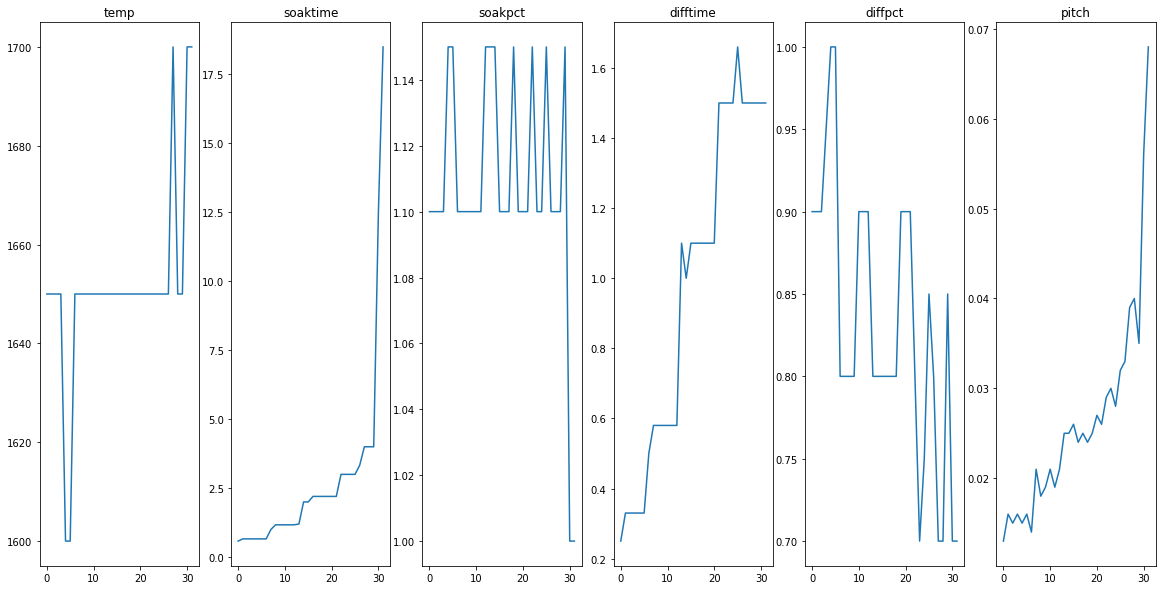

In [25]:
df = pd.read_excel('./data-table-B12.xls')
cols = df.columns
fig, ax = plt.subplots(1, 6, figsize=(20, 10))

for i, col in enumerate(cols):
    ax[i].plot(df[col])
    ax[i].title.set_text(col)

Based on the text, it mentions that the dataset is based on heat treating of gears. Let y = pitch, since heat treatment of gears may be dependent on temperature, soak amount and time.

In [26]:
y = df['pitch']
features = list(df.loc[:,df.columns != 'pitch'].columns)

Split the data into training and testing set. Use 60/40.
Hold out 40% for the end to see how well this model did.

In [27]:
df_train = df.sample(n=int(len(df)*0.60))
df_predict = df.loc[~df.index.isin(df_train.index)]

#### Linear Regression and Residuals

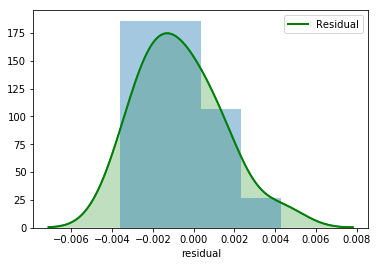

In [28]:
model = sm.OLS(df['pitch'], df[features])
reg = model.fit()
reg_full = model.fit()
sse_full = reg_full.ssr
mse_full = reg_full.mse_model

df_train['yhat'] = reg.predict(df_train[features])
df_train['residual'] = df_train['pitch'] - df_train['yhat'];

sns.distplot(df_train['residual'], kde=True)
sns.distplot(df_train['residual'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Residual", color ="green");

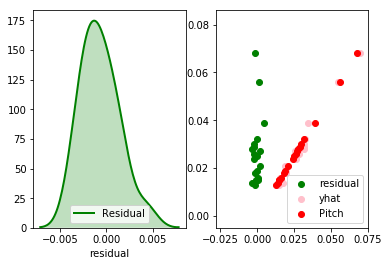

In [29]:
fig, ax = plt.subplots(1, 2) 
sns.distplot(df_train['residual'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Residual", color ="green", ax = ax[0]);

plt.scatter(df_train['residual'], df_train['pitch'], color="green", label="residual");
plt.scatter(df_train['yhat'], df_train['pitch'], color="pink", label="yhat");
plt.scatter(df_train['pitch'], df_train['pitch'], color="red", label="Pitch");
plt.legend();

In [30]:
infl = reg.get_influence()
frame_infl = infl.summary_frame()

df_residual = pd.DataFrame()
df_residual['student_resid'] = frame_infl['student_resid']
df_residual['standard_resid'] = frame_infl['standard_resid']
df_residual['resid_press'] = infl.resid_press
df_residual['cooks_d'] = frame_infl['cooks_d']
df_residual['r_student'] = -frame_infl['hat_diag']* infl.resid_press

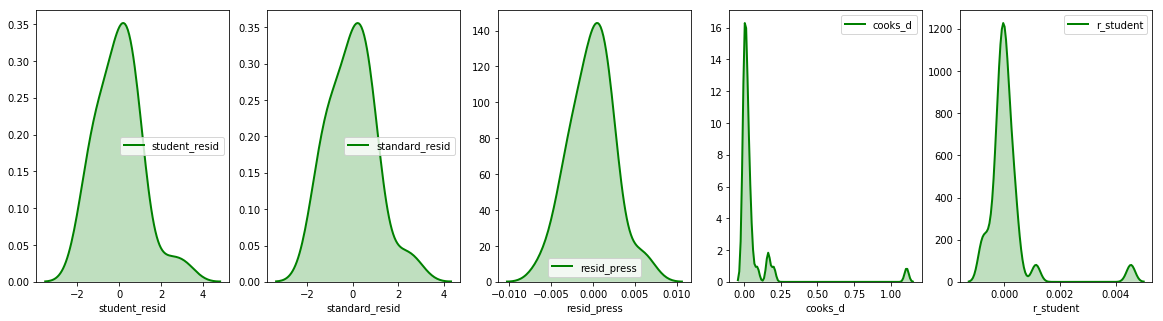

In [31]:
plot_this = ['student_resid', 'standard_resid', 'resid_press','cooks_d','r_student']

fig, ax = plt.subplots(1, 5,figsize=(20,5))

for i, p in enumerate(plot_this):
    sns.distplot(df_residual[p], hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = p, color ="green", ax = ax[i]) 
plt.show()

Residual Press looks good.

#### Transformations

In [36]:
def graph(d, transform_feature, features, transformation_type=None):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10)) 

    if transformation_type:
        d[transform_feature] = eval(transformation_type+"(d['"+transform_feature+"'])")
    try:
        model = sm.OLS(d['pitch'], d[features])
        reg = model.fit()
        d['yhat_'+transform_feature]  = reg.predict(d[features])
        d['residual'] = d['yhat_'+transform_feature]-d['pitch']
        label=transform_feature+' '+transformation_type
        sns.distplot(d['residual'], hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = label, color ="green", ax = ax[0]);
        plt.scatter(d['residual'], d['pitch'], color="green", label=label);
        plt.scatter(d['yhat_'+transform_feature], d['pitch'], color="pink", label="yhat");
        plt.scatter(d['pitch'], d['pitch'], color="red", label="Pitch");
        plt.legend();
        plt.show()
        return d
    except:
        print ('Transformed to inf or zeros')
        pass

Transformed to inf or zeros


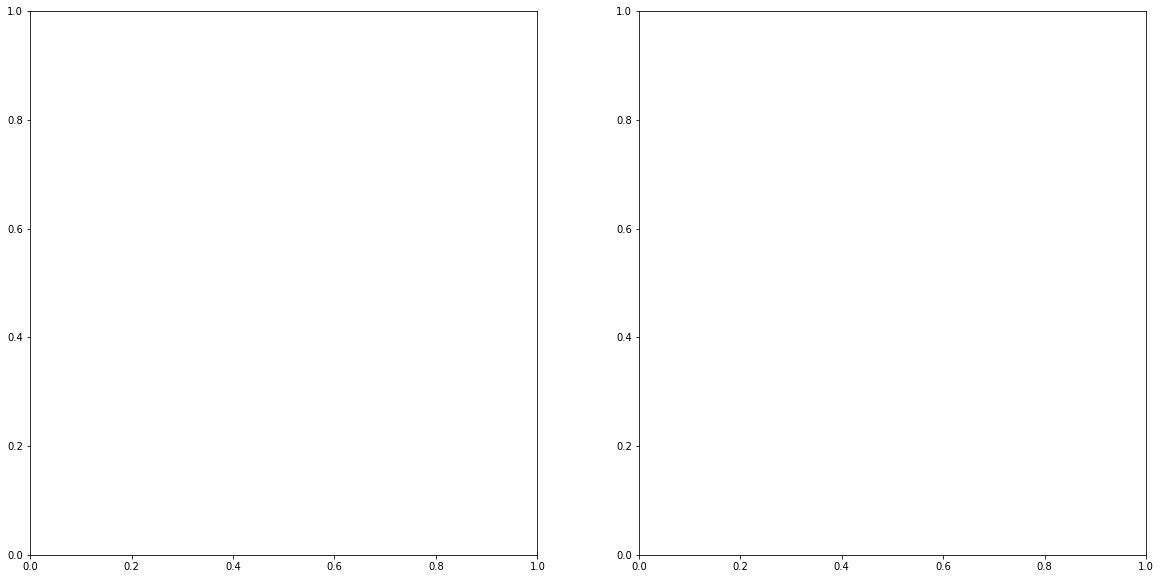

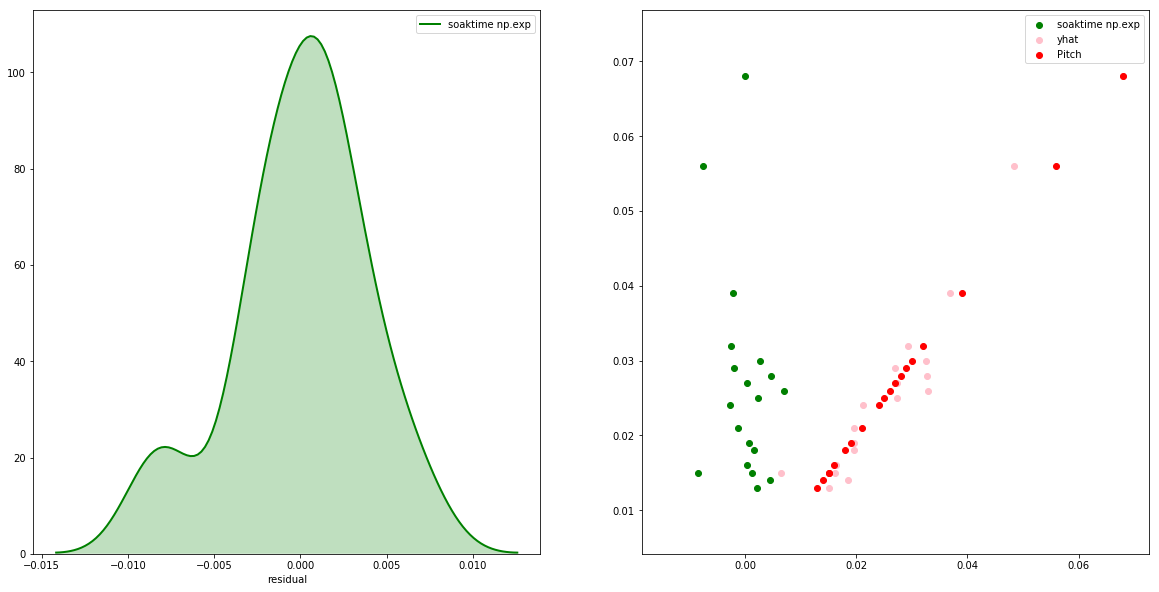

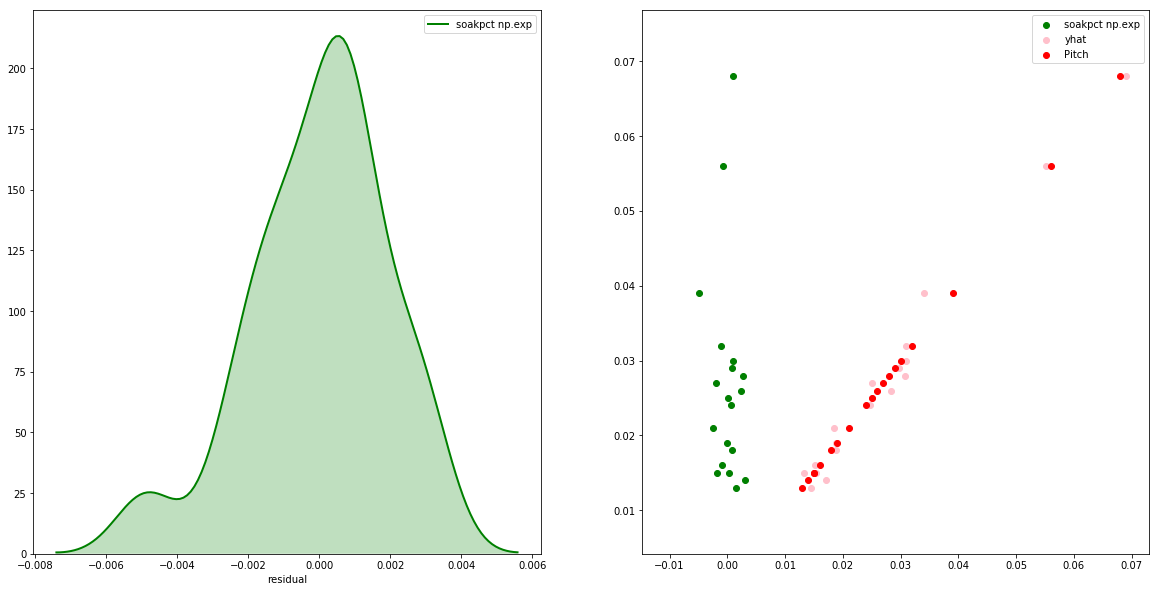

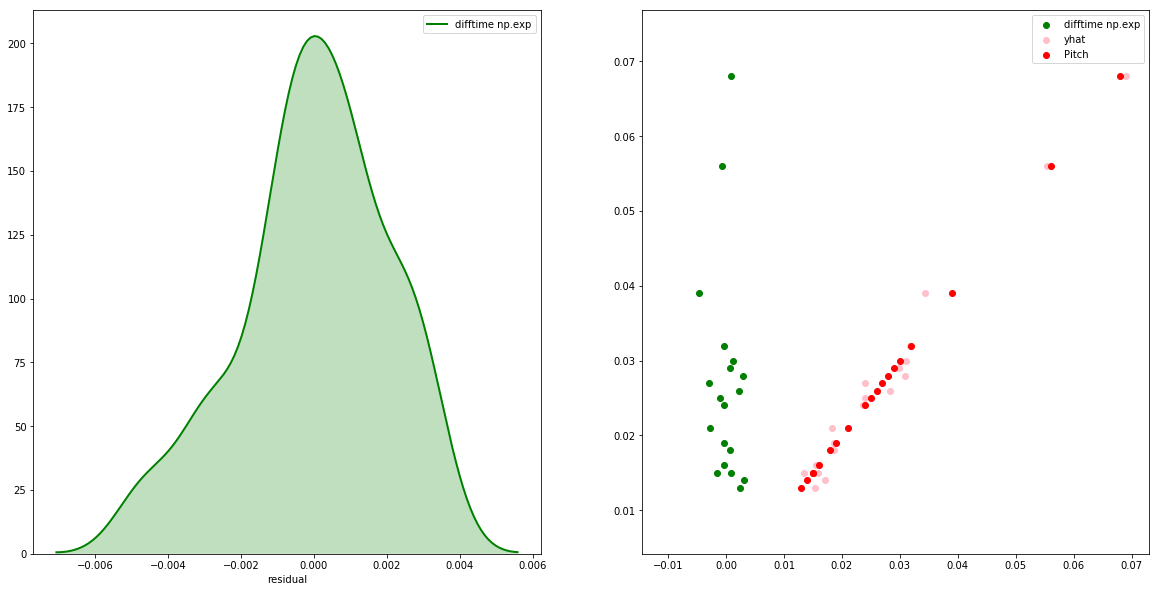

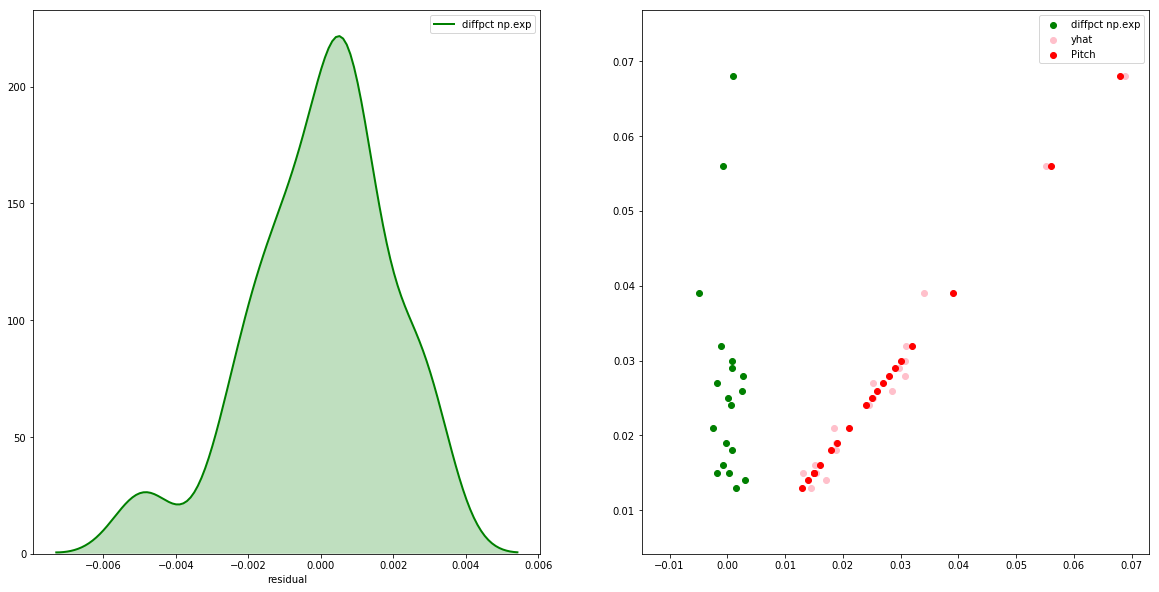

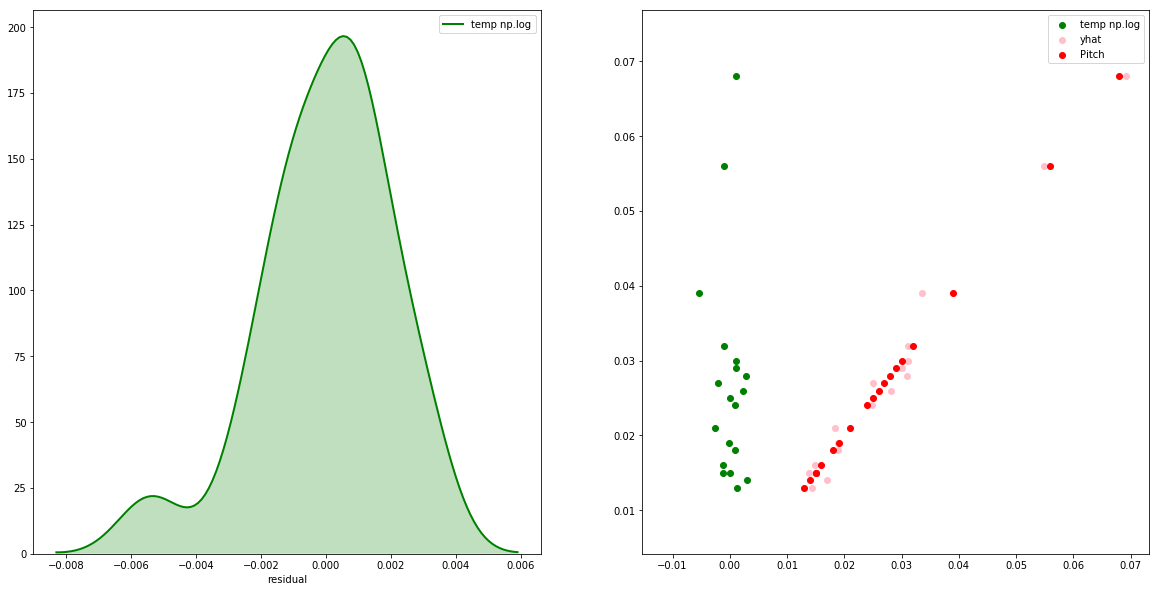

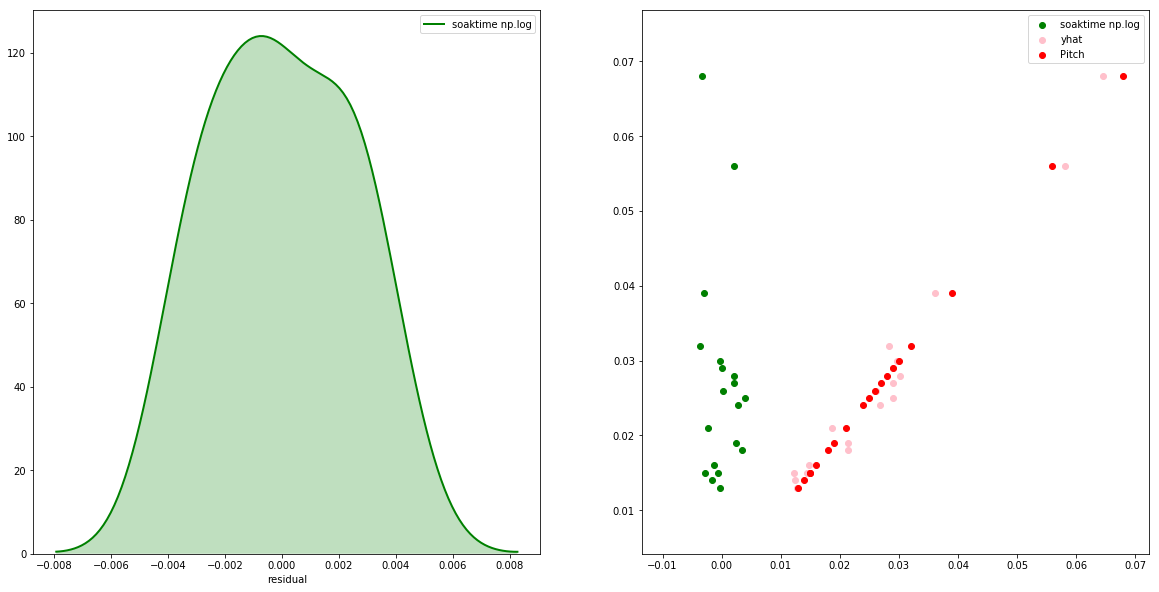

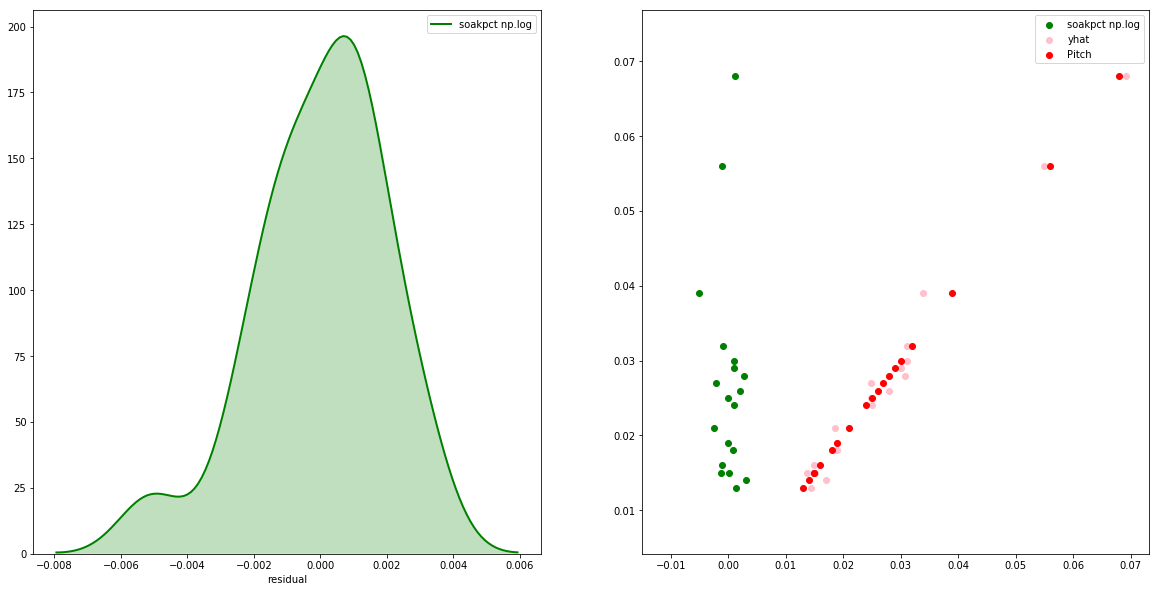

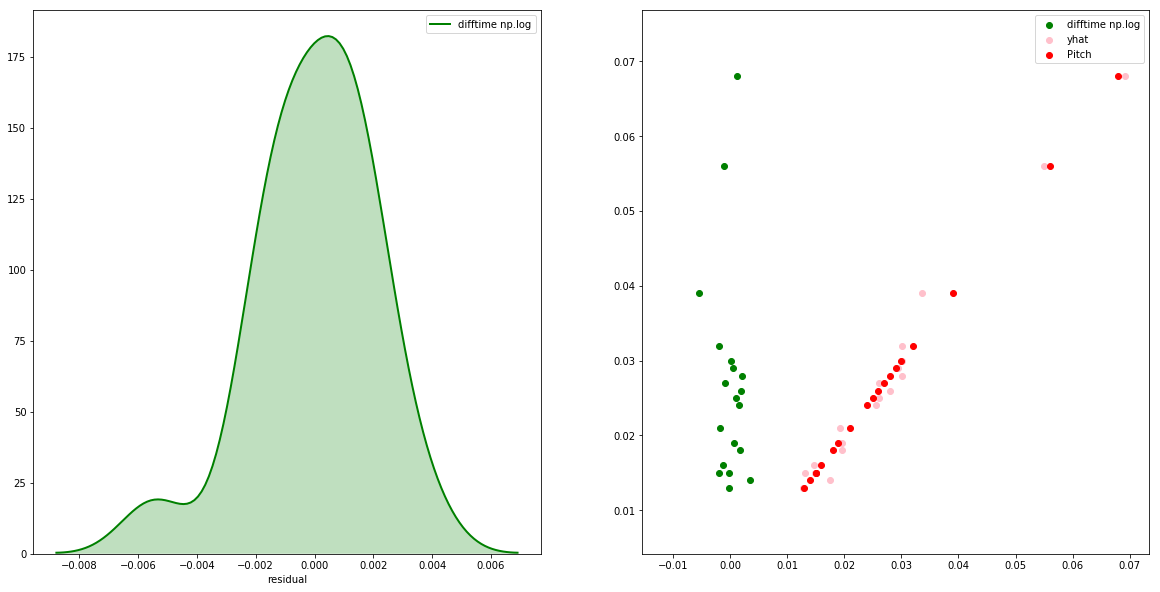

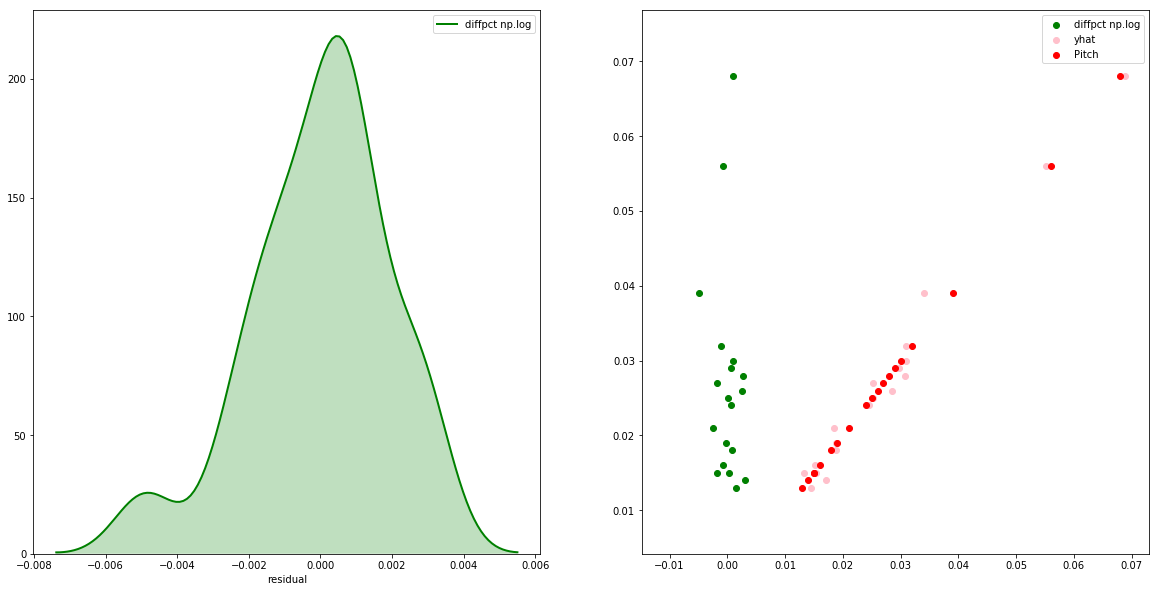

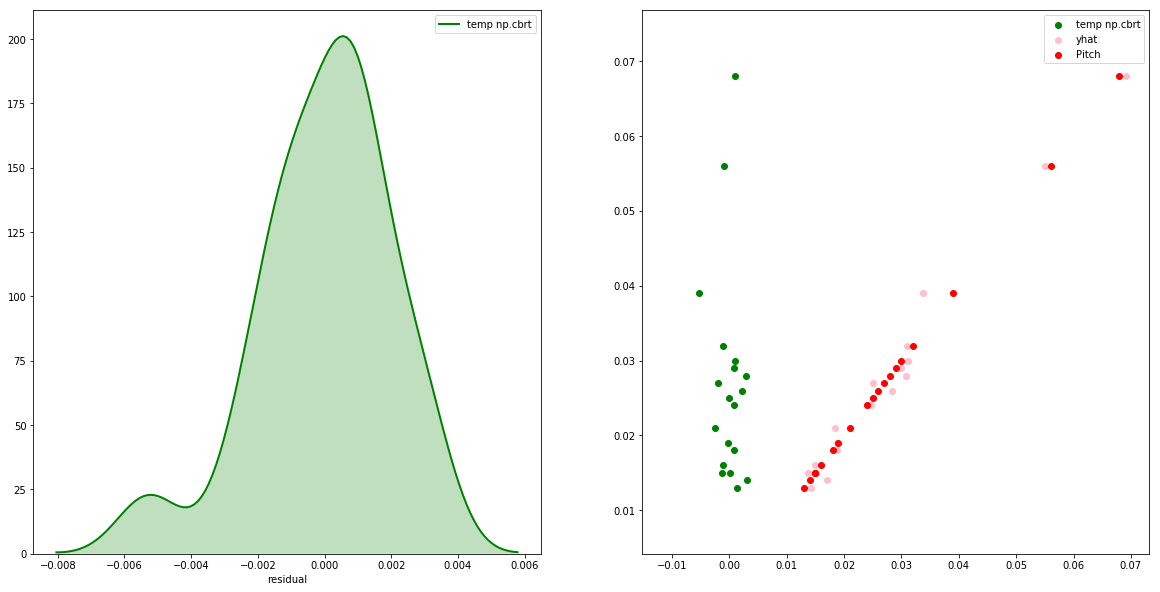

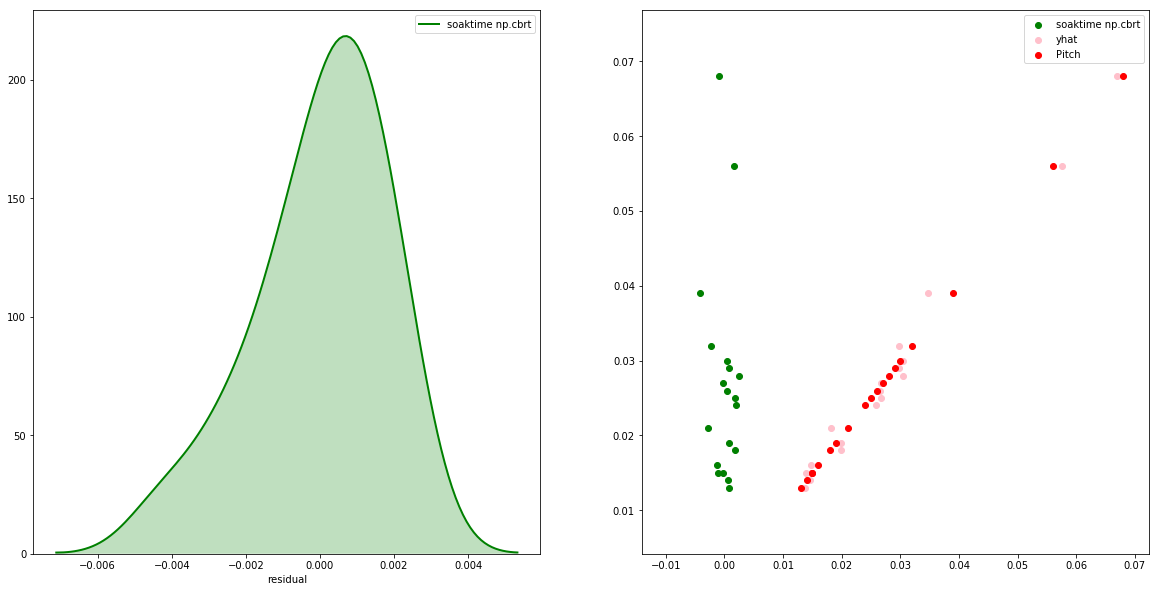

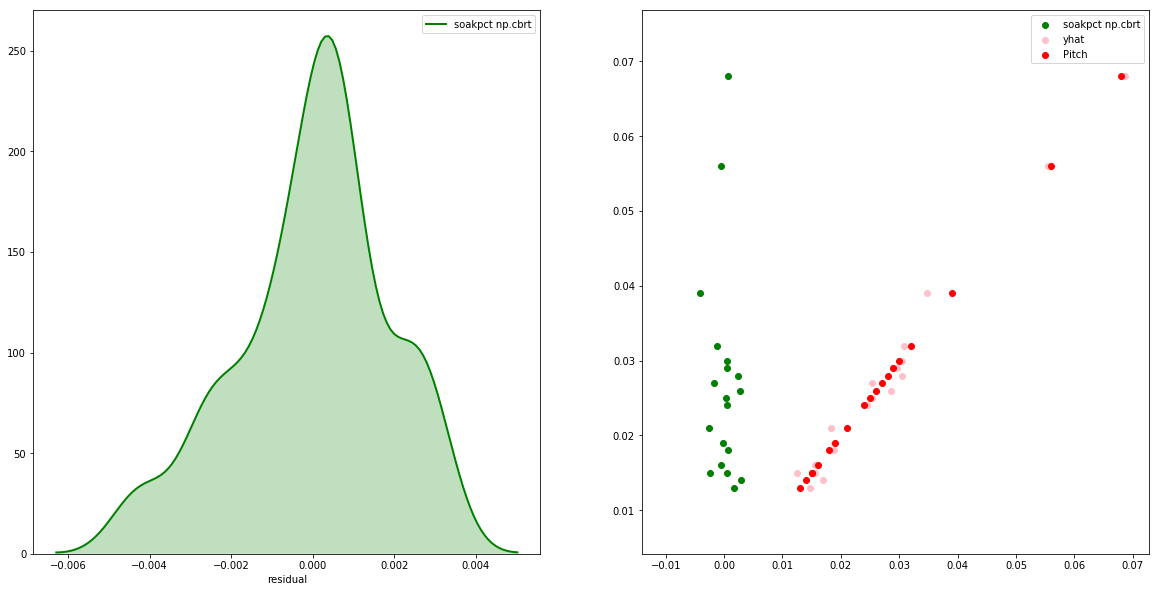

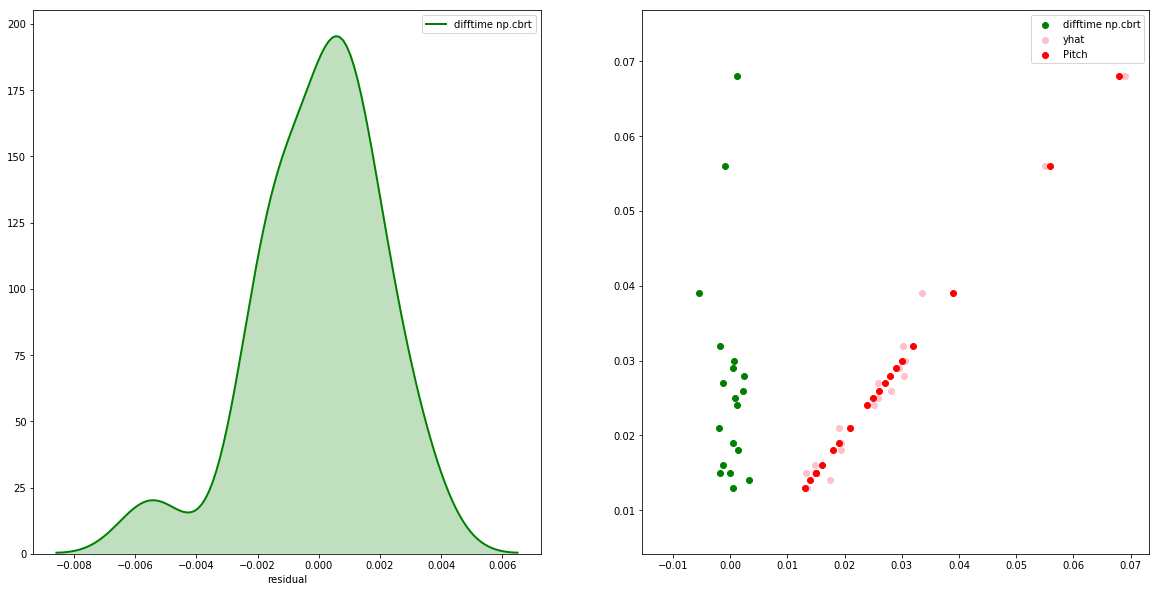

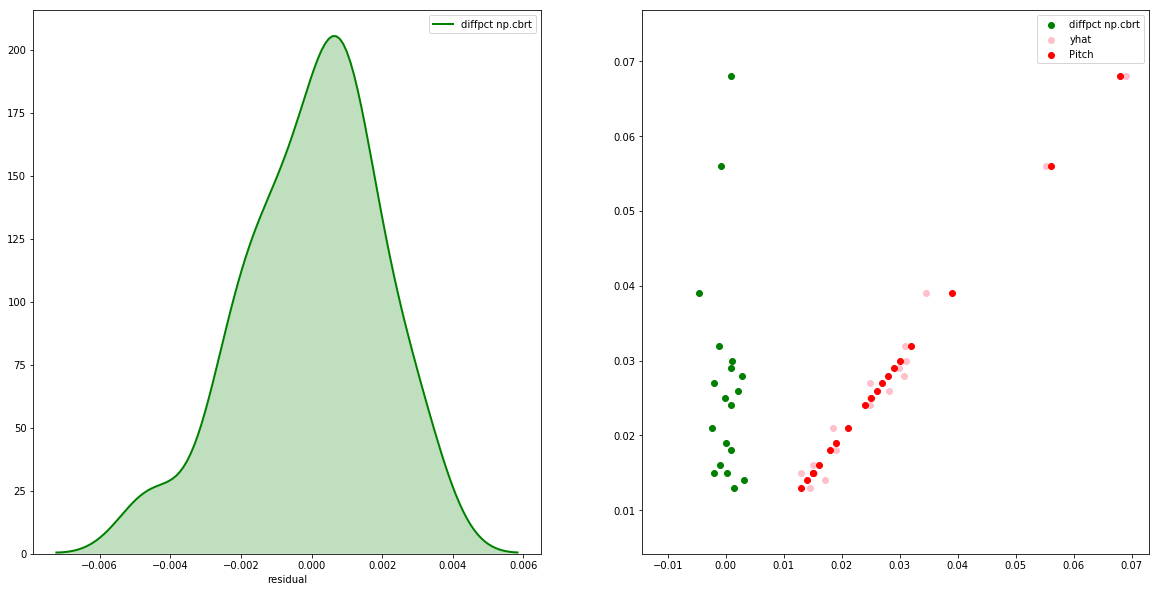

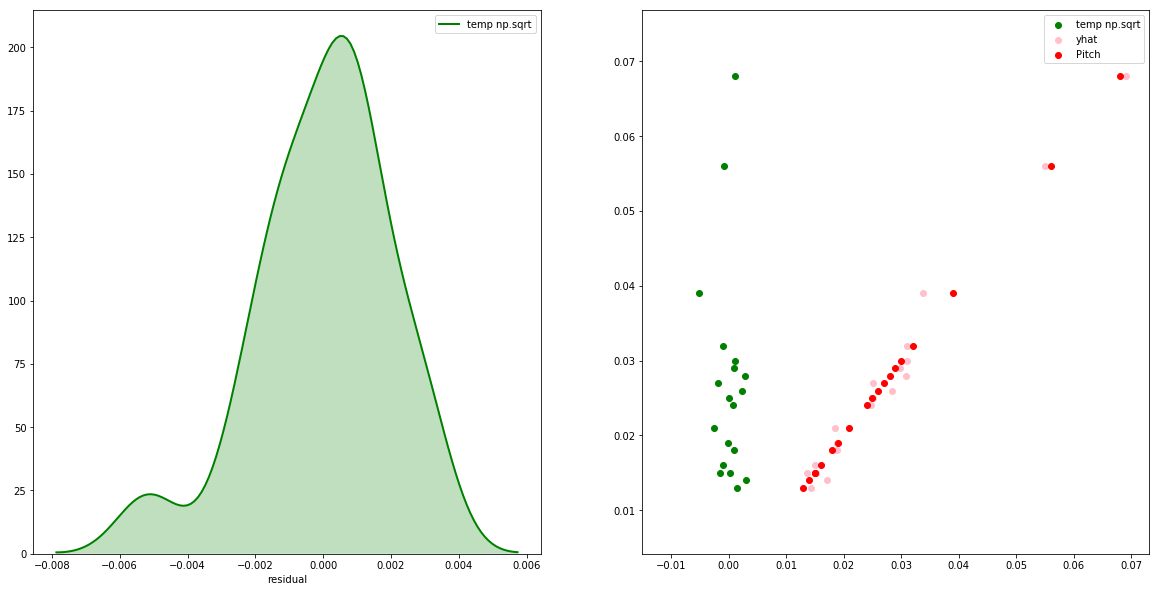

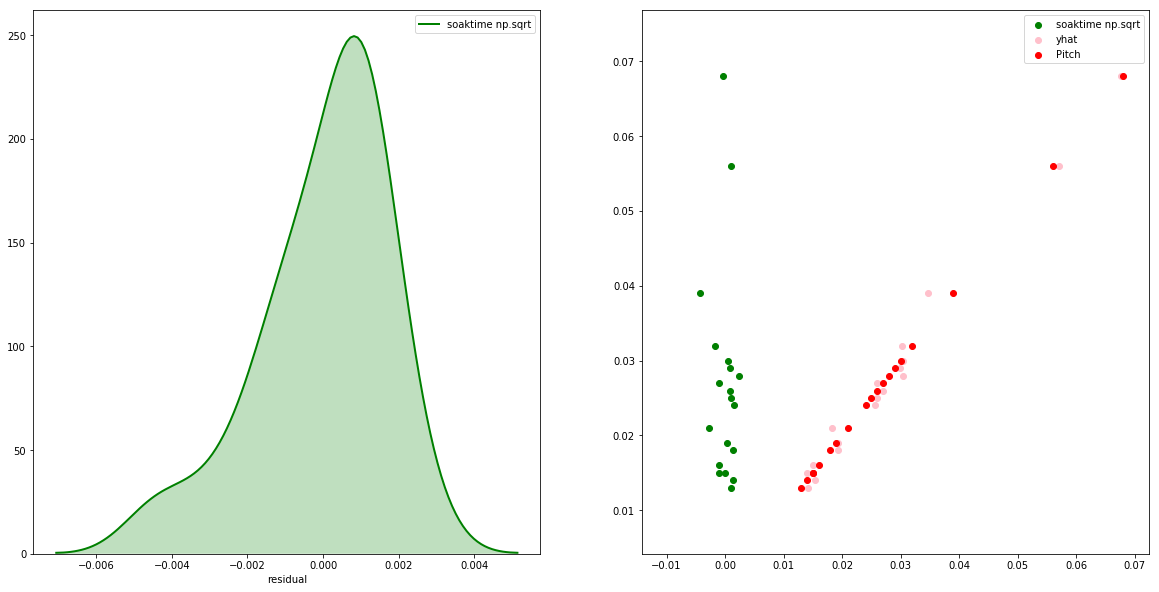

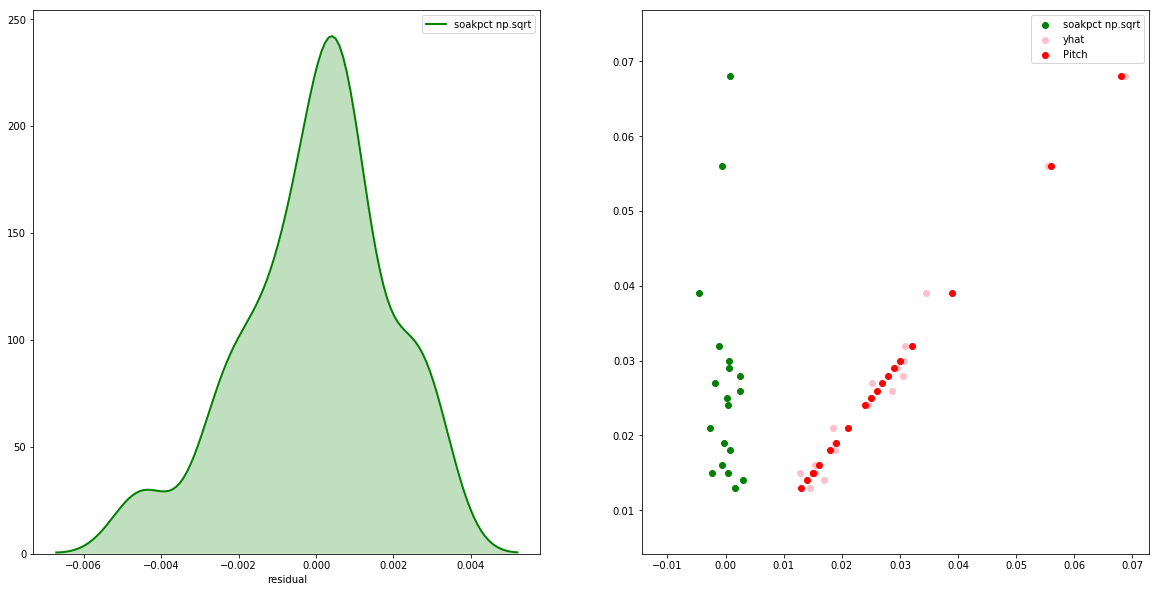

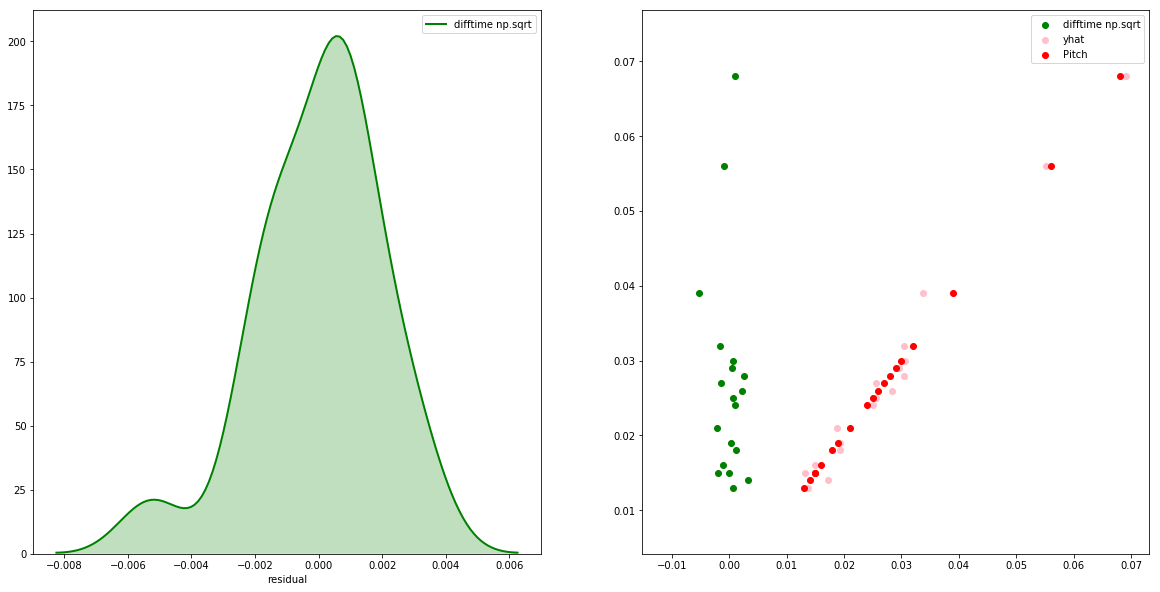

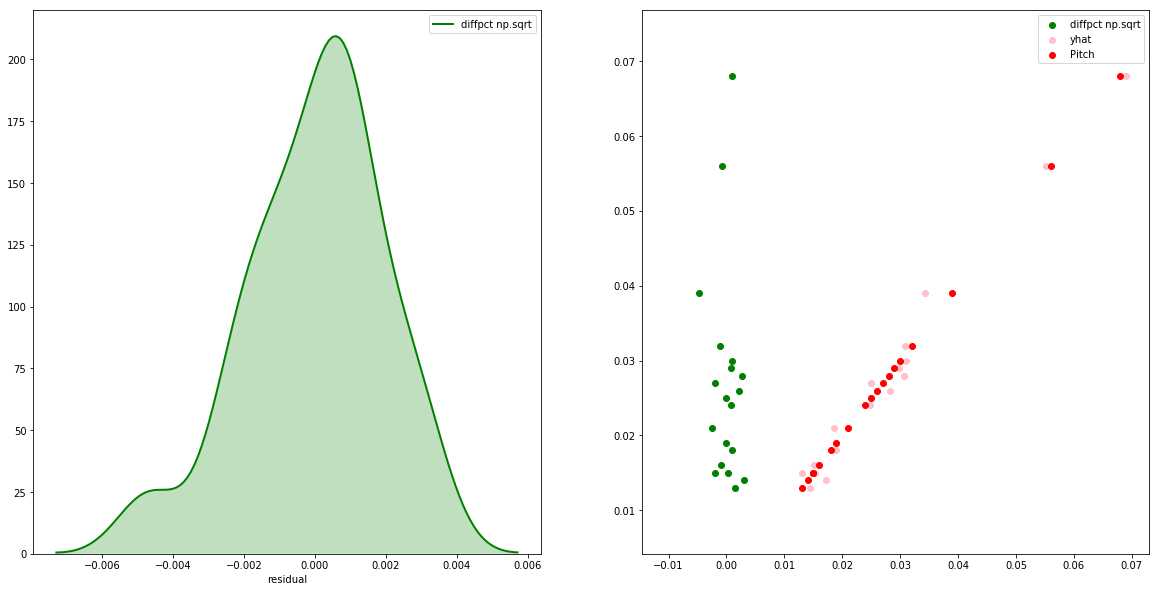

In [37]:
transform_type = [ "np.exp", "np.log", "np.cbrt", "np.sqrt" ]
for transform in transform_type:
    for transform_feature in features:
        f_idx = features.index(transform_feature)
        fts = features[:f_idx] + features[f_idx:]
        d = df_train.copy()
        graph(d, transform_feature, fts, transform);

Transform soaktime to natural log<br>
Diffpct to cube root<br>

#### Regressor Selector

In [38]:
def ols(df, regressor, y):
    model = sm.OLS(df[y], df[regressor])
    reg = model.fit();
    mse = reg.mse_model
    A = np.identity(len(reg.params))
    sse = reg.ssr
    reg.f_test(A)
    return {"model": reg, "sse": sse, "mse":mse, "pvalues":reg.pvalues,  "fvalue": reg.fvalue, "f_pvalue": reg.f_pvalue}

Forward Selection

In [39]:
corr = df.corr()['pitch'].sort_values(ascending=False)
features = list(corr.keys()[1:])
results = []
f_in = 0
for i in range(1,6):
    for c in itertools.combinations(features, i):
        reg = ols(df, list(c), 'pitch')
        partial_f = (reg["sse"] - sse_full)/(i)/mse_full
        if (partial_f > f_in):
            f_in = partial_f
            results.append(c)
        else:
            break
list(*zip(*results))

['soaktime']

Backward Selection

In [40]:
results = features
t_in = 0.01
t_out=0.05
for i in range(6,1,-1):
    for c in itertools.combinations(features, i):
        reg = ols(df, list(c), 'pitch')
        worst_p = reg['pvalues'].max()
        if (worst_p > t_out):
            worst_feature = reg['pvalues'].idxmax()
            features.remove(worst_feature)
        else:
            break
list(set(results))

['soaktime', 'difftime', 'temp']

Stepwise Selection

In [41]:
results = []
f_in = 0
threshold_in=0.01
threshold_out = 0.05

# forward step
f_in = 0
for i in range(1,6):
    for c in itertools.combinations(features, i):
        reg = ols(df, list(c), 'pitch')
        partial_f = (reg["sse"] - sse_full)/(i)/mse_full
        if (partial_f > f_in):
            f_in = partial_f
            results.append(c)
        else:
            break
results = list(*zip(*results))

# backward step
for i in range(6,1,-1):
    for c in itertools.combinations(results, i):
        reg = ols(df, list(c), 'pitch')
        worst_p = reg['pvalues'].max()
        if (worst_p > t_out):
            worst_feature = reg['pvalues'].idxmax()
            features.remove(worst_feature)
        else:
            break
list(set(results))

['soaktime']

In [42]:
# try all possible combination 
all_results=[]
for i in range(1,6):
    for c in itertools.combinations(features, i):
        all_results.append(ols(df, list(c), 'pitch'))
model = pd.DataFrame(all_results)
m = len(df['pitch'])
p = len(features)
hat_sigma_squared = (1/(m - p -1)) * min(model['sse'])
model['C_p'] = (1/m) * (model['sse'] + 2 * p * hat_sigma_squared )
best_model = model.loc[model['C_p'].idxmin()]
best_model['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  pitch   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              1810.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):                    4.58e-33
Time:                        14:28:34   Log-Likelihood:                          151.98
No. Observations:                  32   AIC:                                     -298.0
Df Residuals:                      29   BIC:                                     -293.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
soaktime       0.0024      0.000     18.832      0.000       0.002       0.003
difftime       0.0086      0.001      8.812      0.000       0.007       0.011
temp        6.746e-06   5.55e-07     12.162      0.000    5.61e-06    7.88e-06
==============================================================================
Omnibus:                        6.589   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                4.934
Skew:                           0.796   Prob(JB):                       0.0848
Kurtosis:                       4.079   Cond. No.                     4.17e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
model.sort_values(by='C_p', ascending=False)

,f_pvalue,fvalue,model,mse,pvalues,sse,C_p
0,1.290261e-10,88.846536,<statsmodels.regression.linear_model.Regressio...,0.019593,soaktime 1.290261e-10 dtype: float64,0.006836,0.000215
2,5.533321e-14,165.895387,<statsmodels.regression.linear_model.Regressio...,0.022268,temp 5.533321e-14 dtype: float64,0.004161,0.000131
1,5.046065e-18,326.955045,<statsmodels.regression.linear_model.Regressio...,0.024140,difftime 5.046065e-18 dtype: float64,0.002289,0.000072
5,5.057779e-18,198.383386,<statsmodels.regression.linear_model.Regressio...,0.012286,difftime 0.000001 temp 0.013089 dtyp...,0.001858,0.000059
3,4.587025e-23,447.724524,<statsmodels.regression.linear_model.Regressio...,0.012786,soaktime 7.117433e-08 difftime 4.543605e...,0.000857,0.000028
4,2.314084e-26,752.595904,<statsmodels.regression.linear_model.Regressio...,0.012956,soaktime 3.927545e-15 temp 2.233841e...,0.000516,0.000017
6,4.584028e-33,1809.543760,<statsmodels.regression.linear_model.Regressio...,0.008763,soaktime 8.329953e-18 difftime 1.071827e...,0.000140,0.000005


Selected feature Cp: soaktime

In [65]:
df_train_boxcox = df_train1[selected_feature+['pitch']]

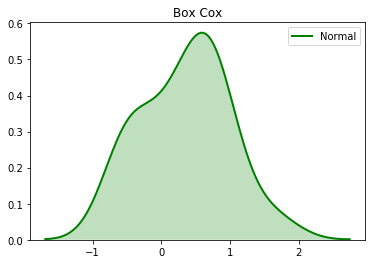

In [63]:
x_train = np.reshape(df_train_boxcox[selected_feature].values, (-1, 1))
fitted_data, fitted_lambda = stats.boxcox(x_train.flatten()) 
fig, ax = plt.subplots(1) 
sns.distplot(fitted_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Normal", color ="green") 
plt.title('Box Cox')
plt.show()

#### Reperform Analysis Based on Initial Findings<br>
1. Selected feature only soaktime
2. Transform soaktime to np.log

In [53]:
df_train1 = pd.DataFrame()
df_train1['soaktime_log'] = np.log(df_train['soaktime'])
df_train1['pitch'] = df_train['pitch']

selected_feature = ['soaktime_log']

In [54]:
model = sm.OLS(df_train1['pitch'], df_train1[selected_feature])
reg = model.fit()

#### Prediction on Test Set

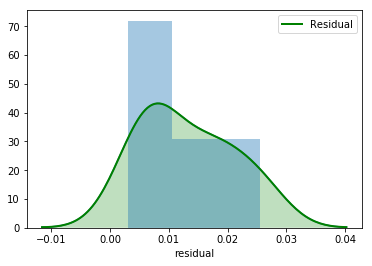

In [63]:
# predict df_predict
df_predict['soaktime_log'] = np.log(df_predict['soaktime'])

yhat = reg.predict(df_predict[selected_feature])
df_predict['yhat'] = yhat
df_predict['residual'] = df_predict['pitch'] - df_predict['yhat'];

sns.distplot(df_predict['residual'], kde=True)
sns.distplot(df_predict['residual'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Residual", color ="green");

The model selected was SOAKTIME with a natural log transformation. The selection was based on forward, backward, stepwise, Cp selection. The transformation was based on transforming to natural log. There is a slight devation from normal and has couple of outliers.